# SDXL Model Pipeline Setup - Lightning Fix Applied
Supports 9 distillation models with proper scheduler configuration

In [1]:
# Imports and Configuration
import sys
import torch
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DDIMScheduler,
    LCMScheduler,
    TCDScheduler,
    DiffusionPipeline,
)
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

%load_ext autoreload
%autoreload 2

print("✓ Imports completed")

# ---------- Configuration ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"

model_configs = {
    'base': {'steps': 100, 'recommended_cfg': 5.0},
    'dmd': {'steps': 4, 'recommended_cfg': 0.0},
    'turbo': {'steps': 4, 'recommended_cfg': 0.0},
    'lightning': {'steps': 4, 'recommended_cfg': 0.0},
#    'lcm': {'steps': 4, 'recommended_cfg': 1.0},
#    'hyper': {'steps': 8, 'recommended_cfg': 5.0},
#    'pcm': {'steps': 4, 'recommended_cfg': 2.0},
#    'tcd': {'steps': 4, 'recommended_cfg': 3.0},
#    'flash': {'steps': 4, 'recommended_cfg': 2.0}
}

print(f"✓ Configuration set - Device: {device}, Dtype: {weights_dtype}")
print(f"✓ Available models: {list(model_configs.keys())}")



def load_model(distillation_type=None, weights_dtype=torch.float16, device='cuda'):
    """
    Load SDXL models with specified distillation type.
    
    Returns:
      'base'/'None': (pipe, base_unet, base_scheduler)
      others:       (pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler)
    """
    kind = ('base' if distillation_type in (None, 'base') else distillation_type).lower()
    print(f"Loading {kind.upper()} model...")

    # ---- base (always build this once for config/safety) ----
    base_unet = UNet2DConditionModel.from_pretrained(
        basemodel_id, subfolder="unet", torch_dtype=weights_dtype
    ).to(device)

    pipe = StableDiffusionXLPipeline.from_pretrained(
        basemodel_id,
        unet=base_unet,
        torch_dtype=weights_dtype,
        use_safetensors=True,
    )
    base_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler = base_scheduler
    pipe.to(device=device, dtype=weights_dtype)

    if kind == 'base':
        return pipe, base_unet, base_scheduler

    # fresh UNet matching base config (required for state_dict load)
    distilled_unet = UNet2DConditionModel.from_config(pipe.unet.config).to(device, dtype=weights_dtype)

    if kind == 'dmd':
        repo_name, ckpt_name = "tianweiy/DMD2", "dmd2_sdxl_4step_unet_fp16.bin"
        state = torch.load(hf_hub_download(repo_name, ckpt_name), map_location='cpu')
        distilled_unet.load_state_dict(state if isinstance(state, dict) else state['state_dict'])
        distilled_scheduler = LCMScheduler.from_config(pipe.scheduler.config)

    elif kind == 'lightning':
        repo, ckpt = "ByteDance/SDXL-Lightning", "sdxl_lightning_4step_unet.safetensors"
        state = load_file(hf_hub_download(repo, ckpt))
        distilled_unet.load_state_dict(state, strict=True)
        # FIX: Use EulerDiscreteScheduler with trailing timesteps for both schedulers
        distilled_scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
        base_scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    elif kind == 'turbo':
        # turbo ships a full UNet; pull that directly
        distilled_unet = UNet2DConditionModel.from_pretrained(
            "stabilityai/sdxl-turbo", subfolder="unet", torch_dtype=weights_dtype, variant="fp16"
        ).to(device)
        distilled_scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    elif kind == 'lcm':
        distilled_unet = UNet2DConditionModel.from_pretrained(
            "latent-consistency/lcm-sdxl", torch_dtype=weights_dtype
        ).to(device)
        distilled_scheduler = LCMScheduler.from_config(pipe.scheduler.config)

    elif kind == 'hyper':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("ByteDance/Hyper-SD",
                               weight_name="Hyper-SDXL-8steps-CFG-lora.safetensors",
                               adapter_name="hyper-sdxl-8step")
        pipe.set_adapters(["hyper-sdxl-8step"], adapter_weights=[1.0])
        distilled_unet = pipe.unet
        distilled_scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

    elif kind == 'pcm':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("wangfuyun/PCM_Weights",
                               weight_name="pcm_sdxl_smallcfg_4step_converted.safetensors",
                               subfolder="sdxl",
                               adapter_name="pcm-lora")
        pipe.set_adapters(["pcm-lora"], adapter_weights=[1.0])
        distilled_unet = pipe.unet
        distilled_scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    elif kind == 'tcd':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("h1t/TCD-SDXL-LoRA", adapter_name="tcd-lora")
        pipe.set_adapters(["tcd-lora"], adapter_weights=[1.0])
        distilled_unet = pipe.unet
        distilled_scheduler = TCDScheduler.from_config(pipe.scheduler.config)

    elif kind == 'flash':
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=weights_dtype)
        pipe.load_lora_weights("jasperai/flash-sdxl",
                               weight_name="pytorch_lora_weights.safetensors",
                               adapter_name="flash-sdxl")
        pipe.set_adapters(["flash-sdxl"], adapter_weights=[1.0])
        pipe.fuse_lora()
        distilled_unet = pipe.unet
        distilled_scheduler = LCMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    else:
        raise ValueError(f"Unknown distillation type: '{distillation_type}'. "
                         f"Available: {', '.join(sorted(model_configs.keys()))}")

    # IMPORTANT: actually use the distilled UNet
    if hasattr(pipe, "unet") and distilled_unet is not pipe.unet:
        pipe.unet = distilled_unet
    pipe.scheduler = distilled_scheduler
    pipe.to(device=device, dtype=weights_dtype)
    return pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler


def load_pipe(distillation_type='base', weights_dtype=torch.float16, device='cuda'):
    """
    Returns a ready-to-sample pipeline with the correct UNet and scheduler.
    """
    pipe_result = load_model(distillation_type, weights_dtype, device)
    # result already sets the right scheduler/UNet when not 'base'
    pipe = pipe_result[0]
    print(f"✓ {('base' if distillation_type in (None, 'base') else distillation_type).upper()} pipeline ready")
    return pipe

/mnt/batch/tasks/shared/LS_root/mounts/clusters/a100-ml/code/Users/Normalized-Attention-Guidance/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports completed
✓ Configuration set - Device: cuda, Dtype: torch.bfloat16
✓ Available models: ['base', 'dmd', 'turbo', 'lightning']


100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


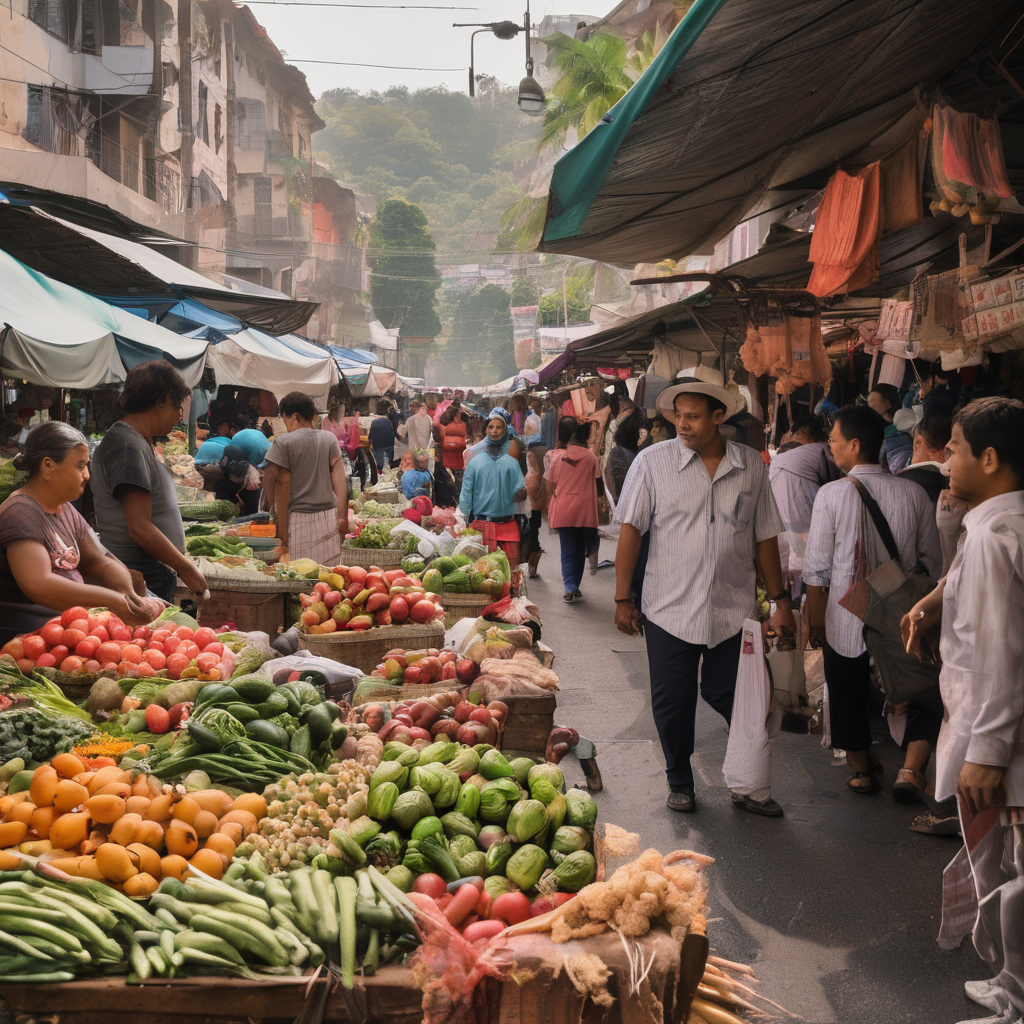

In [8]:
import torch
from diffusers import StableDiffusionXLPipeline

torch.backends.cuda.matmul.allow_tf32 = True        # A100-friendly speed
torch.set_float32_matmul_precision("high")          # prefer TF32 on fp32 ops

model_id = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,    # A100 supports bf16 natively
    use_safetensors=True,
)

pipe.to("cuda")


prompt = "A bustling marketplace with vendors selling fresh fruits and vegetables"

# Generate a small batch efficiently on A100 (adjust batch_size as you like)
generator = torch.Generator(device="cuda").manual_seed(2014)
images = pipe(
    prompt=[prompt],            # batch of 4
    num_inference_steps=100,         # 25–40 typical
    guidance_scale=5.5,             # 4.5–7.0 works well
    height=1024,
    width=1024,
    generator=generator,
).images

images[0]

## Test Across Select Models
Run tests on multiple models with first 10 prompts and first seed, organized by model folder

In [2]:
import json
import os
from pathlib import Path
from tqdm import tqdm

# ---------- Load prompts from JSON file ----------
prompts_file = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json"
output_base_dir = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results"

# Load prompts
with open(prompts_file, 'r') as f:
    prompts_data = json.load(f)

# Use only first 10 prompts
prompts_data = prompts_data[:10]

print(f"Loaded {len(prompts_data)} prompts from {prompts_file}")
print(f"Output base directory: {output_base_dir}")

# ---------- Generate and save images organized by folder ----------
total_generated = 0

for model_name, model_config in model_configs.items():
    steps = model_config["steps"]
    cfg = model_config["recommended_cfg"]
    
    # Load the model pipeline
    pipe = load_pipe(model_name, weights_dtype=weights_dtype, device=device)
    
    # Create model-specific output directory
    model_output_dir = os.path.join(output_base_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    print(f"\n{'='*60}")
    print(f"Testing model: {model_name}")
    print(f"Output directory: {model_output_dir}")
    print(f"{'='*60}")
    
    generated_count = 0
    
    for idx, item in enumerate(tqdm(prompts_data, desc=f"{model_name} progress")):
        prompt = item["prompt"]
        negative_prompt = item["negative_prompt"]
        seeds = item.get("seeds", [42])
        
        # Use first seed for quick generation
        seed = 2014
        
        try:
            # Generate image
            generator = torch.Generator(device=device).manual_seed(2014)
            image = pipe(
                prompt,
                guidance_scale=cfg,
                num_inference_steps=steps,
                generator=generator,
                width=512, height=512,
            ).images[0]
            
            # Create output filename
            group = item.get("group", "unknown")
            filename = f"{idx:04d}_{group}_{seed}.png"
            filepath = os.path.join(model_output_dir, filename)
            
            # Save image
            image.save(filepath)
            generated_count += 1
            total_generated += 1
            
        except Exception as e:
            print(f"Error generating image for prompt {idx} with {model_name}: {e}")
            continue
    
    print(f"\n✓ {model_name}: Generated and saved {generated_count} images")

print(f"\n{'='*60}")
print(f"✓ Total generated and saved: {total_generated} images")
print(f"✓ Models tested: {list(model_configs.keys())}")
print(f"{'='*60}")

Loaded 10 prompts from /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json
Output base directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results
Loading BASE model...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


✓ BASE pipeline ready

Testing model: base
Output directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results/base


base progress: 100%|██████████| 10/10 [01:28<00:00,  8.81s/it]



✓ base: Generated and saved 10 images
Loading DMD model...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]
The config attributes {'interpolation_type': 'linear', 'use_karras_sigmas': False, 'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


✓ DMD pipeline ready

Testing model: dmd
Output directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results/dmd


dmd progress: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]



✓ dmd: Generated and saved 10 images
Loading TURBO model...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


✓ TURBO pipeline ready

Testing model: turbo
Output directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results/turbo


turbo progress: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]



✓ turbo: Generated and saved 10 images
Loading LIGHTNING model...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.02it/s]


✓ LIGHTNING pipeline ready

Testing model: lightning
Output directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results/lightning


lightning progress: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]



✓ lightning: Generated and saved 10 images

✓ Total generated and saved: 40 images
✓ Models tested: ['base', 'dmd', 'turbo', 'lightning']
